## Importing Libraries

In [5]:
import pandas as pd
import numpy as np
import re, string, nltk, seaborn as sns, matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)

# one-time NLTK downloads
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load & Explore the Dataset

In [6]:
# Replace the path with your own if needed
csv_path = "Tweets.csv"      # file inside the Kaggle download
df = pd.read_csv("Tweets.csv")

# Keep only tweet text and sentiment label
df = df[['text', 'airline_sentiment']]
df.head()


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [7]:
print(f"Rows: {df.shape[0]}\nColumns: {df.shape[1]}")
print("\nSentiment distribution:")
display(df['airline_sentiment'].value_counts())

Rows: 14640
Columns: 2

Sentiment distribution:


airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

## Text Cleaning & Pre-processing

In [8]:
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()

    def clean(self, text: str) -> str:
        text = text.lower()
        text = re.sub(r"http\\S+|www\\S+", " ", text)           # URLs
        text = re.sub(r"@\\w+|#\\w+", " ", text)                # @mentions & hashtags
        text = re.sub(r"[^a-z\\s]", " ", text)                  # punctuation / numbers
        text = re.sub(r"\\s+", " ", text).strip()               # extra spaces
        return text

    def remove_stopwords(self, text: str) -> str:
        return " ".join([w for w in text.split() if w not in self.stop_words])

    def stem(self, text: str) -> str:
        return " ".join([self.stemmer.stem(w) for w in text.split()])

    def transform(self, text: str) -> str:
        text = self.clean(text)
        text = self.remove_stopwords(text)
        text = self.stem(text)
        return text

tp = TextPreprocessor()
df['clean_text'] = df['text'].apply(tp.transform)
df[['text', 'clean_text']].head()

,text,clean_text
0,@VirginAmerica What @dhepburn said.,virginamerica dhepburn said
1,@VirginAmerica plus you've added commercials t...,virginamerica plu ad commerci experi tacki
2,@VirginAmerica I didn't today... Must mean I n...,virginamerica today must mean need take anoth ...
3,@VirginAmerica it's really aggressive to blast...,virginamerica realli aggress blast obnoxi ente...
4,@VirginAmerica and it's a really big bad thing...,virginamerica realli big bad thing


## Train / Test Split

In [10]:
X = df['clean_text']
y = df['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

In [11]:
## Vectorization

In [12]:
tfidf_vec  = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
count_vec  = CountVectorizer(max_features=5000, ngram_range=(1,2))

Xtr_tfidf, Xts_tfidf = tfidf_vec.fit_transform(X_train), tfidf_vec.transform(X_test)
Xtr_cnt , Xts_cnt   = count_vec.fit_transform(X_train),  count_vec.transform(X_test)

## Model Training & Evaluation Helper

In [13]:
def evaluate(model, Xtr, ytr, Xts, yts):
    model.fit(Xtr, ytr)
    preds = model.predict(Xts)
    return {
        "Accuracy" : accuracy_score(yts, preds),
        "Precision": precision_score(yts, preds, average='weighted', zero_division=0),
        "Recall"   : recall_score(yts, preds, average='weighted', zero_division=0),
        "F1"       : f1_score(yts, preds, average='weighted', zero_division=0),
        "Model"    : model.__class__.__name__
    }

## Run Experiments

In [14]:
results = []

for name, (Xtr, Xts) in {"TF-IDF": (Xtr_tfidf, Xts_tfidf),
                         "Count":  (Xtr_cnt , Xts_cnt )}.items():

    for clf in [MultinomialNB(), 
                LogisticRegression(max_iter=1000, random_state=42),
                LinearSVC(max_iter=1000, random_state=42)]:

        res = evaluate(clf, Xtr, y_train, Xts, y_test)
        res["Vectorizer"] = name
        results.append(res)

results_df = pd.DataFrame(results).sort_values("F1", ascending=False)
results_df


,Accuracy,Precision,Recall,F1,Model,Vectorizer
4,0.783925,0.779994,0.783925,0.781243,LogisticRegression,Count
1,0.786202,0.777232,0.786202,0.774288,LogisticRegression,TF-IDF
2,0.771630,0.763139,0.771630,0.765631,LinearSVC,TF-IDF
3,0.767760,0.761878,0.767760,0.764248,MultinomialNB,Count
5,0.755237,0.753616,0.755237,0.754236,LinearSVC,Count
0,0.744763,0.752132,0.744763,0.706772,MultinomialNB,TF-IDF


## Best Model Analysis

In [18]:
best_row = results_df.iloc[0]
print(best_row)

# Retrain best model on full training data
best_vec  = tfidf_vec if best_row["Vectorizer"] == "TF-IDF" else count_vec
best_Xtr  = Xtr_tfidf if best_row["Vectorizer"] == "TF-IDF" else Xtr_cnt
best_Xts  = Xts_tfidf if best_row["Vectorizer"] == "TF-IDF" else Xts_cnt
best_clf  = MultinomialNB() if best_row["Model"] == "MultinomialNB" else \
            LogisticRegression(max_iter=1000, random_state=42) if best_row["Model"]=="LogisticRegression" else \
            LinearSVC(max_iter=1000, random_state=42)

best_clf.fit(best_Xtr, y_train)
y_pred = best_clf.predict(best_Xts)

print(classification_report(y_test, y_pred))


Accuracy                0.783925
Precision               0.779994
Recall                  0.783925
F1                      0.781243
Model         LogisticRegression
Vectorizer                 Count
Name: 4, dtype: object
              precision    recall  f1-score   support

    negative       0.85      0.88      0.87      2753
     neutral       0.60      0.58      0.59       930
    positive       0.75      0.66      0.70       709

    accuracy                           0.78      4392
   macro avg       0.73      0.71      0.72      4392
weighted avg       0.78      0.78      0.78      4392



## Visualizatiion

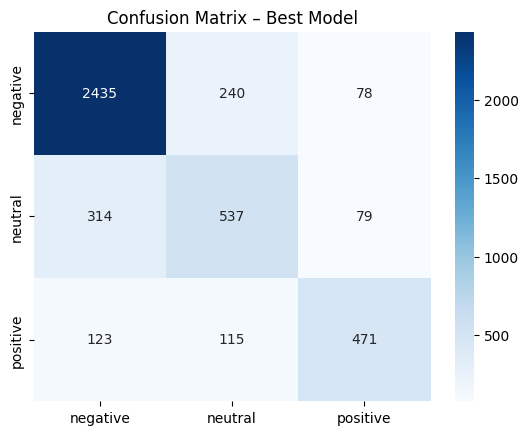

In [19]:
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt="d", cmap="Blues",
            xticklabels=best_clf.classes_,
            yticklabels=best_clf.classes_)
plt.title("Confusion Matrix – Best Model")
plt.show()

## Naive Bayes

In [16]:
if isinstance(best_clf, MultinomialNB):
    log_probs = best_clf.feature_log_prob_
    features  = np.array(best_vec.get_feature_names_out())

    for i, label in enumerate(best_clf.classes_):
        top = log_probs[i].argsort()[-10:][::-1]
        print(f"\nTop terms for '{label}':")
        for t in features[top]:
            print(f"  {t}")

## Key Insight

In [17]:
print("Key Take-aways:")
print("• Class imbalance: ", df['airline_sentiment'].value_counts().to_dict())
print("• Best vectorizer-model combo from grid above.")
print("• Frequent negative tokens typically relate to delays, \"worst\", \"terrible\" etc.")
print("• Positive tweets emphasise staff friendliness, on-time performance.")


Key Take-aways:
• Class imbalance:  {'negative': 9178, 'neutral': 3099, 'positive': 2363}
• Best vectorizer-model combo from grid above.
• Frequent negative tokens typically relate to delays, "worst", "terrible" etc.
• Positive tweets emphasise staff friendliness, on-time performance.
